# Defining self-intersecting polygons

This tutorial shows how to use the [ComplexPolySlab](../_autosummary/tidy3d.plugins.polyslab.ComplexPolySlab.html) plugin in `Tidy3D` to deal with self-intersecting polygon that occurs during extrusion in a slanted polyslab.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td

from tidy3d.plugins.polyslab import ComplexPolySlab


## Example 1: concave polygon on the top with positive sidewall angle

Let's consider a concave polygon as shown in the following figure. As we dilate the polygon, the length of the edge in the middle will approach 0, and the two vertices at the end of the edge can be degenerate. Further dilation will result in a self-intersecting polygon. The collapsing of the two neighboring vertices is known as one type of edge events. There are other types of edge events as well, while our plugin at the moment will focus on this type of edge event.

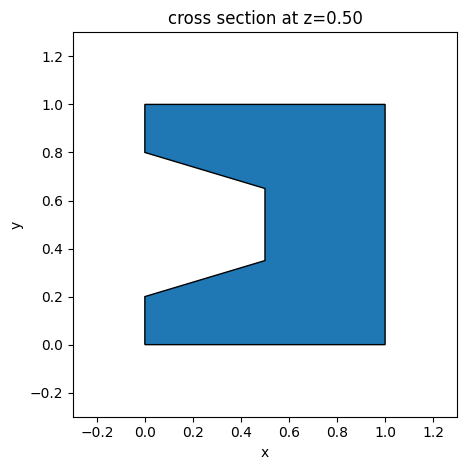

In [2]:
vertices = (
    (0, 0),
    (1, 0),
    (1, 1),
    (0, 1),
    (0, 0.8),
    (0.5, 0.65),
    (0.5, 0.35),
    (0, 0.2),
)
s = td.PolySlab(
    vertices=vertices,
    slab_bounds=(0, 1),
    axis=2,
    sidewall_angle=0,
    reference_plane="top",
)
s.plot(z=0.5)
plt.show()


For a slanted polyslab where this polygon is at the top, self-intersection can occur as the polygon is extruded to the base when the sidewall angle is large. Since `td.PolySlab` only deals with simple polyslab, an error message will be displayed in this case.

In [3]:
sidewall_angle = np.pi / 4
try:
    s = td.PolySlab(
        vertices=vertices,
        slab_bounds=(0, 1),
        axis=2,
        sidewall_angle=sidewall_angle,
        reference_plane="top",
    )
except Exception as e:
    pass


[16:43:55] ERROR: Sidewall angle or structure thickness is so    ]8;id=732268;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/geometry/polyslab.py\polyslab.py]8;;\:]8;id=940906;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/geometry/polyslab.py#199\199]8;;\
           large that the polygon is self-intersecting during                   
           extrusion. Please either reduce structure thickness                  
           to be < 2.016e-01, or use our plugin                                 
           'ComplexPolySlab' to divide the complex polyslab into                
           a list of simple polyslabs.                                          

### Dividing a complex polyslab into sub-polyslabs

The plugin `ComplexPolySlab` can divide such a complex polyslab into a list of simple polyslabs. The procedure of setting up the object is the same as in `td.PolySlab`:

In [4]:
s = ComplexPolySlab(
    vertices=vertices,
    slab_bounds=(0, 1),
    axis=2,
    sidewall_angle=sidewall_angle,
    reference_plane="top",
)


We can obtain the division result in the form of a list of simple polyslabs, or combined into a `GeometryGroup`. As shown below, the entire polyslab will be divided into 3 simple polyslabsl

In [5]:
# To obtain the divided polyslabs, there are two approaches:
# 1) a list of divided polyslabs
sub_polyslabs = s.sub_polyslabs

# 2) geometry group containing the divided polyslabs
polyslabs_group = s.geometry_group

print(f"The number of sub-polyslabs in the list is {len(sub_polyslabs)}.")
print(
    f"The number of sub-polyslabs in geometry group is {len(polyslabs_group.geometries)}."
)


The number of sub-polyslabs in the list is 3.
The number of sub-polyslabs in geometry group is 3.


### Define a simulation
Now let's make a simple simulation with a `ComplexPolySlab` object.

In [6]:
mat = td.Medium(permittivity=2)

# Three equivalent approaches
# 1) from sub-polyslabs
struct_list = [td.Structure(geometry=poly, medium=mat) for poly in s.sub_polyslabs]

# 2) from geometry group
struct_list = [td.Structure(geometry=s.geometry_group, medium=mat)]

# 3) directly obtain the structure with a user-specified medium
struct_list = [s.to_structure(mat)]


In [7]:
sim = td.Simulation(
    run_time=1e-12,
    size=(4, 4, 2),
    center=(0.5, 0.5, 0.5),
    grid_spec=td.GridSpec.auto(wavelength=1.0),
    structures=struct_list,
)


Note: `Tidy3D` is warning us that our Simulation does not contain sources. In this case, since we are using the simulation as a demonstration and are not running any simulations, we may safely ignore this warning throughout this notebook.

### Visualization

Three characteristic normal cross sections are illustrated below. The polygon near the top looks similar to the supplied polygon. Somewhere between $z=0.75$ $\mu$m and $z=0.95$ $\mu$m, a vertex-vertex crossing event happens, and the shape of the polygon changes. Between $z=0.75$ $\mu$m and $z=0.5$ $\mu$m, another event occurs, and the shape evolves to a simple box.

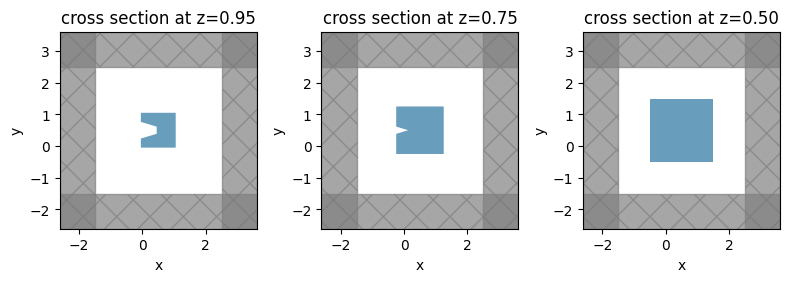

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4), layout="tight")
sim.plot(z=0.95, ax=ax[0])
sim.plot(z=0.75, ax=ax[1])
sim.plot(z=0.5, ax=ax[2])
plt.show()


## Example 2: GDS import

Both `PolySlab` and `ComplexPolySlab` can be constructed from a `gdstk.Cell`. To illustrate this, let's make a GDS cell with the aforementioned concave polygon, and load it with `.from_gds` classmethod.

In [9]:
# add the concave polygon to the gds cell

lib = gdstk.Library()
cell = lib.new_cell("SI")
poly = gdstk.Polygon(vertices, layer=0)
_ = cell.add(poly)


### Loading a GDS cell into `ComplexPolySlab`

In [10]:
# obtain a list of polyslabs
geo_list = ComplexPolySlab.from_gds(
    cell,
    gds_layer=0,
    axis=2,
    slab_bounds=(0, 1),
    sidewall_angle=np.pi / 4,
    reference_plane="top",
)


In [11]:
structure = td.Structure(
    geometry=td.GeometryGroup(geometries=geo_list),
    medium=mat,
)

sim = td.Simulation(
    run_time=1e-12,
    size=(4, 4, 2),
    center=(0.5, 0.5, 0.5),
    grid_spec=td.GridSpec.auto(wavelength=1.0),
    structures=[structure],
)


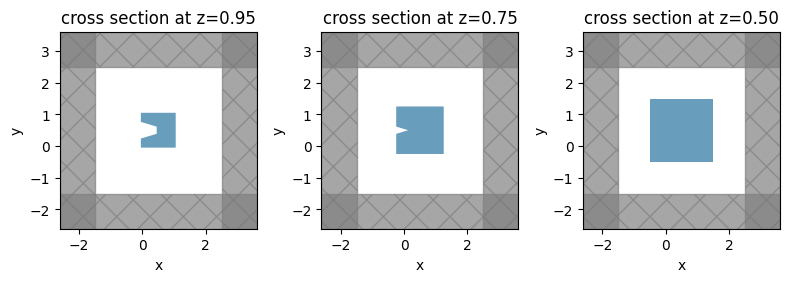

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4), layout="tight")
sim.plot(z=0.95, ax=ax[0])
sim.plot(z=0.75, ax=ax[1])
sim.plot(z=0.5, ax=ax[2])
plt.show()


Note, however, that loading a GDS cell can be more generally done with `Geometry.from_gds`, which will support not only self-intersections like in `ComplexPolySlab`, but also polygons with holes. The interface is almost identical, except it returns a geometry subclass, instead of a list, that can be used directly in a `Structure`:

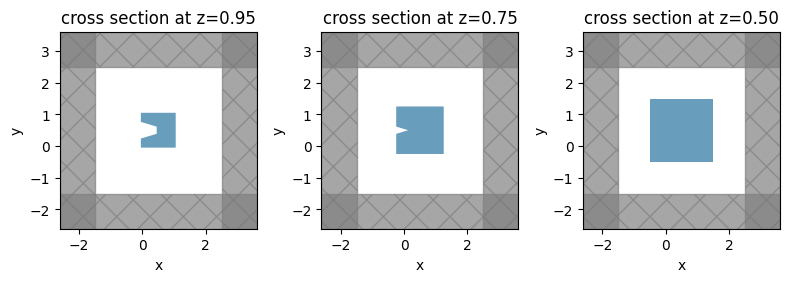

In [13]:
# obtain a list of polyslabs
geo = td.Geometry.from_gds(
    cell,
    gds_layer=0,
    axis=2,
    slab_bounds=(0, 1),
    sidewall_angle=np.pi / 4,
    reference_plane="top",
)

structure = td.Structure(geometry=geo, medium=mat)

sim = td.Simulation(
    run_time=1e-12,
    size=(4, 4, 2),
    center=(0.5, 0.5, 0.5),
    grid_spec=td.GridSpec.auto(wavelength=1.0),
    structures=[structure],
)

fig, ax = plt.subplots(1, 3, figsize=(8, 4), layout="tight")
sim.plot(z=0.95, ax=ax[0])
sim.plot(z=0.75, ax=ax[1])
sim.plot(z=0.5, ax=ax[2])
plt.show()

After going through this tutorial, you have learned how to define a self-intersecting polyslab. If you are new to `Tidy3D` or the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials and [example library](https://www.flexcompute.com/tidy3d/examples/) before starting your own simulation advanture. 